# Generative Adversarial Network

- https://github.com/znxlwm/pytorch-generative-model-collections

In [152]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda available!')

## MNIST

- Generatorは62次元のランダムベクトルzを入力として1チャンネルの28x28の画像を出力
- ConvTranspose2d
- 入力は4Dテンソル (N, C1, H1, W1)  出力は4Dテンソル (N, C2, H2, W2)
- H2 = (H1-1)*stride - 2*padding + kernel_size
- W2 = (W1-1)*stride - 2*padding + kernel_size
- 1つめのConvTranspose2d $(7-1)*2 - 2*1 + 4 = 14$
- 2つめのConvTranspose2d $(14-1)*2 - 2*1 + 4 = 28$

In [120]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [121]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
#         print('input:', input.size())
        x = self.fc(input)
#         print('x1:', x.size())
        x = x.view(-1, 128, 7, 7)
#         print('x2:', x.size())
        x = self.deconv(x)
        return x

In [51]:
# Generatorのサイズテスト
G = Generator()
input = Variable(torch.rand((32, 62)))
out = G(input)
print(out.size())

input: torch.Size([32, 62])
x1: torch.Size([32, 6272])
x2: torch.Size([32, 128, 7, 7])
torch.Size([32, 1, 28, 28])


In [58]:
G

Generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): ConvTranspose2d (64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)

- 28x28の画像を入力して本物か偽物かを表す0-1の数値を出力する
- MaxPooling2dを使わずにstrideで画像サイズを半分にする

In [122]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
    
    def forward(self, input):
#         print('input:', input.size())
        x = self.conv(input)
#         print('x1:', x.size())
        x = x.view(-1, 128 * 7 * 7)
#         print('x2:', x.size())
        x = self.fc(x)
        return x

In [53]:
# Discriminatorのサイズテスト
D = Discriminator()
input = Variable(torch.rand((32, 1, 28, 28)))
out = D(input)
print(out.size())

input: torch.Size([32, 1, 28, 28])
x1: torch.Size([32, 128, 7, 7])
x2: torch.Size([32, 6272])
torch.Size([32, 1])


In [59]:
D

Discriminator(
  (conv): Sequential(
    (0): Conv2d (1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(0.2)
    (2): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=1024)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
    (3): Linear(in_features=1024, out_features=1)
    (4): Sigmoid()
  )
)

- GeneratorとDiscriminatorはそれぞれoptimizerがある
- 参考先では `loss.cuda()` しているがlossはパラメータがないのでしなくてOK
    - https://discuss.pytorch.org/t/what-exactly-does-loss-cuda-do/7450

In [123]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16
log_dir = './logs'

In [124]:
# initialize network
G = Generator()
D = Discriminator()
if cuda:
    G.cuda()
    D.cuda()

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [125]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)        

- detach()の必要性
- https://github.com/pytorch/examples/issues/116
- D_optimizerにはDのパラメータしか渡しておらず、D_optimizer.step()してもGeneratorのパラメータは更新されないためdetach()しなくても結果はかわらない
- ただ、明示的にdetach()することでfake_imagesを通じてGeneratorに勾配が伝搬することを防ぎ、計算が高速化される

In [162]:
def train(D, G, criterion, D_optimizer, G_optimizer, data_loader):
    # 訓練モードへ
    D.train()
    G.train()

    # 本物のラベルは1
    y_real = Variable(torch.ones(batch_size, 1))
    # 偽物のラベルは0
    y_fake = Variable(torch.zeros(batch_size, 1))
    if cuda:
        y_real = y_real.cuda()
        y_fake = y_fake.cuda()

    D_running_loss = 0
    G_running_loss = 0
    for batch_idx, (real_images, _) in enumerate(data_loader):
        # 一番最後、バッチサイズに満たない場合は無視する
        if real_images.size()[0] != batch_size:
            break

        z = torch.rand((batch_size, z_dim))
        if cuda:
            real_images, z = real_images.cuda(), z.cuda()
        real_images, z = Variable(real_images), Variable(z)

        # Discriminatorの更新
        D_optimizer.zero_grad()

        # Discriminatorにとって本物画像の認識結果は1（本物）に近いほどよい
        D_real = D(real_images)
        D_real_loss = criterion(D_real, y_real)

        # DiscriminatorにとってGeneratorが生成した偽物画像の認識結果は0（偽物）に近いほどよい
        # fake_imagesを通じて勾配がGに伝わらないようにdetach()して止める
        fake_images = G(z)
        D_fake = D(fake_images.detach())
        D_fake_loss = criterion(D_fake, y_fake)

        # 2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.data[0]

        # Generatorの更新
        G_optimizer.zero_grad()

        # GeneratorにとってGeneratorが生成した画像の認識結果は1（本物）に近いほどよい
        fake_images = G(z)
        D_fake = D(fake_images)
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.data[0]
    
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss

In [163]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # 生成のもとになる乱数を生成
    sample_z = torch.rand((64, z_dim))
    if cuda:
        sample_z = sample_z.cuda()
    sample_z = Variable(sample_z, volatile=True)
    
    # Generatorでサンプル生成
    samples = G(sample_z).data.cpu()
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [ ]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

# 学習履歴を保存
with open(os.path.join(log_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history, f)

## 結果の分析

In [165]:
with open(os.path.join(log_dir, 'history.pkl'), 'rb') as f:
    history = pickle.load(f)

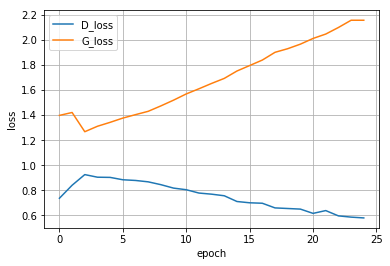

In [166]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

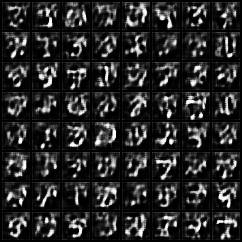

In [167]:
from IPython.display import Image
Image('logs/epoch_001.png')

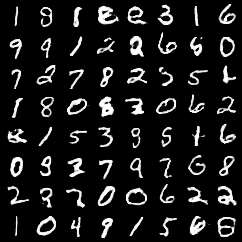

In [168]:
Image('logs/epoch_010.png')

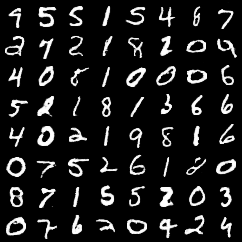

In [169]:
Image('logs/epoch_025.png')